Couldn't connect to the Hub: (ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')), '(Request ID: f9820405-fa9f-469b-9624-06e1753e231a)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_324749/2332791246.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent = torch.load(files[0], map_location=DEVICE)
Optimizing latent:   0%|          | 

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

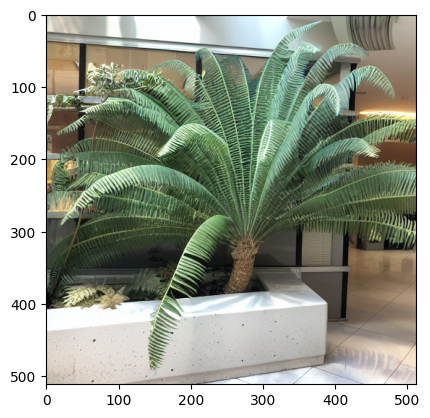

In [3]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from glob import glob
from natsort import natsorted
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import matplotlib.pyplot as plt

import attention_edit
import attention_utils

# --------------------------------------------------
# Configuration
# --------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_ID = "CompVis/stable-diffusion-v1-4"

# Optimization params
NUM_STEPS = 300
LR = 0.01
GUIDANCE_SCALE = 7.5
NUM_DIFFUSION_STEPS = 100

# Paths
default_scene = 'fern'
LATENTS_DIR = f'./results/{default_scene}/inversion/inverted_latent/'
OUTPUT_DIR = f'./gd_base_{default_scene}/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Seeds
torch.manual_seed(8888)
np.random.seed(8888)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8888)

# --------------------------------------------------
# Helpers
# --------------------------------------------------
def get_text_embedding(pipe, prompt: str):
    inp = pipe.tokenizer(
        [prompt], padding='max_length', max_length=pipe.tokenizer.model_max_length,
        truncation=True, return_tensors='pt'
    )
    emb = pipe.text_encoder(inp.input_ids.to(DEVICE))[0]
    return emb


def get_uncond_embedding(pipe, batch_size=1):
    inp = pipe.tokenizer(
        [""] * batch_size, padding='max_length', max_length=pipe.tokenizer.model_max_length,
        return_tensors='pt'
    )
    emb = pipe.text_encoder(inp.input_ids.to(DEVICE))[0]
    return emb


def decode_and_save(pipe, latent, path: str):
    with torch.no_grad():
        imgs = attention_edit.latent2image(pipe.vae, latent)
        if len(imgs):
            img = imgs[0]
            plt.imshow(img)
            plt.savefig(path)

# --------------------------------------------------
# Main
# --------------------------------------------------
def main():
    # 1. Load model + scheduler
    scheduler = DDIMScheduler(
        beta_start=0.00085, beta_end=0.012,
        beta_schedule="scaled_linear", clip_sample=False,
        set_alpha_to_one=False, steps_offset=1
    )
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID, scheduler=scheduler, use_safetensors=True
    ).to(DEVICE)

    # 2. Load latents
    files = natsorted(glob(os.path.join(LATENTS_DIR, '*_final_latent_*.pt')))
    if not files:
        raise RuntimeError(f"No latents in {LATENTS_DIR}")

    latent = torch.load(files[0], map_location=DEVICE)
    if latent.ndim == 4 and latent.shape[0] == 1:
        latent = latent.squeeze(0)
    z = latent.unsqueeze(0).detach().clone().requires_grad_(True)

    prompt = 'a photo of a fern'
    text_emb = get_text_embedding(pipe, prompt)
    uncond_emb = get_uncond_embedding(pipe)
    full_emb = torch.cat([uncond_emb, text_emb], dim=0)

    optimizer = torch.optim.Adam([z], lr=LR)
    pipe.scheduler.set_timesteps(NUM_DIFFUSION_STEPS)

    # 3. Optimize
    for step in tqdm(range(NUM_STEPS), desc="Optimizing latent"):
        optimizer.zero_grad()
        t = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (1,), device=DEVICE)
        noise = torch.randn_like(z) * 3
        z_t = pipe.scheduler.add_noise(z, noise, t)

        # Predict noise
        inp = torch.cat([z_t, z_t], dim=0)
        out = pipe.unet(inp, t, encoder_hidden_states=full_emb).sample
        uncond_pred, text_pred = out.chunk(2)
        pred = uncond_pred + GUIDANCE_SCALE * (text_pred - uncond_pred)

        loss = F.mse_loss(pred, noise)
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            path = os.path.join(OUTPUT_DIR, f"step_{step:04d}.png")
            decode_and_save(pipe, z.detach(), path)

    # final save
    final_path = os.path.join(OUTPUT_DIR, f"step_{NUM_STEPS:04d}_final.png")
    decode_and_save(pipe, z.detach(), final_path)
    print(f"Done! Images in {OUTPUT_DIR}")

if __name__ == '__main__':
    main()


This approach introduces a **training-free method** for **multi-view consistent image generation** using **epipolar attention**, which leverages geometric constraints between cameras to guide the image synthesis process more precisely than full-image attention.

Here's a **step-by-step breakdown** of each section:

---

### 🔧 **4.1 Point Sampling from Epipolar Lines**

**Goal:** Narrow down where to search for corresponding points between views by using **epipolar geometry**.

#### Step-by-step:

1. **Background:**

   * Normally, to find the corresponding point in the reference view, you’d need depth to unproject the 2D point to 3D and reproject it to the reference.
   * However, real-world depth is hard to estimate accurately.

2. **Epipolar Constraint:**

   * For a point `pᵢ` in the **target view**, its corresponding point `pᵢ'` in the **reference view** must lie along an **epipolar line** `lᵢ`.

3. **Epipolar Line Calculation:**

   * Using camera intrinsics `K` and relative pose `(R, t)`:

     $$
     lᵢ = R[t]_× K^{-1} pᵢ
     $$

     where `[t]_×` is the skew-symmetric matrix of the translation vector `t`.

4. **Point Sampling:**

   * Sample multiple points `p′ ∈ P′` along each epipolar line, spaced by the feature map resolution (i.e., per feature pixel).
   * Mask any sampled points that fall outside the image bounds.

---

### 🧭 **4.2 Corresponding Point Searching**

**Goal:** Find the best match among the sampled points along the epipolar line using **feature similarity**.

#### Step-by-step:

1. **Paired Feature Acquisition:**

   * Problem: You can’t extract features from the target image (it's not yet generated).
   * Solution: Use **DDIM inversion**:

     * Invert the **reference image** into noise (`x_R`).
     * Use `x_R` to generate both:

       * A **reconstructed reference view** (by setting pose = 0).
       * The **target view** (by setting correct pose).

2. **Feature Matching:**

   * At each denoising step and U-Net layer, extract corresponding features from both branches.
   * Use **bilinear interpolation** to get features for subpixel epipolar points in the reference.

3. **Compute Similarity:**

   * Use query features `Q` from the **target branch**, and key features `K` from the **reference branch**.
   * Compute attention weights (similarities) using dot product or cosine similarity:

     $$
     \text{sim}(Q_{tgt}(p), K_{ref}(p′))
     $$

---

### 🧩 **4.3 Reference Feature Injection**

**Goal:** Use retrieved reference features to guide the generation of the target view.

#### Step-by-step:

1. **Parameter Duplication:**

   * Create an **epipolar attention block** by **copying weights** from the pretrained self-attention block (training-free).

2. **Feature Aggregation:**

   * Use the computed similarities to weight and sum the reference features:

     $$
     \hat{F}_{src} = \sum_{p′ ∈ P′} \text{sim}(Q_{tgt}(p), K_{ref}(p′)) · F_{src}(p′)
     $$

3. **Feature Fusion:**

   * Combine the retrieved reference features with the original target feature using a blending parameter `α`:

     $$
     F = α \hat{F}_{src} + (1 - α) \hat{F}
     $$

4. **Multi-View Consistency:**

   * Problem: One reference view may not cover the whole scene.
   * Solution: Use multiple **context views** (e.g., previously generated views) and apply epipolar attention to each.
   * Average the retrieved features to synthesize the current novel view.

---

### 🔍 **4.4 Discussion About Epipolar Attention**

**Why epipolar attention is better than full attention:**

1. **Search Efficiency:**

   * **Full attention** compares every pixel with every other → **O(L⁴)** time/memory complexity.
   * **Epipolar attention** reduces this to searching **only along epipolar lines** → **O(L³)**.

2. **Localization Precision:**

   * Full attention often yields **diffused similarity maps**.
   * Epipolar attention uses geometric priors → **sharper and more accurate correspondences**.

3. **Memory & Performance:**

   * By drastically limiting search space and improving relevance, epipolar attention is both **lighter** and **more effective**, especially in multi-view settings.

---

### 🧠 **Summary Diagram** (based on Fig. 3)

| Component                       | Description                                                                                 |
| ------------------------------- | ------------------------------------------------------------------------------------------- |
| **DDIM Inversion**              | Invert reference image to get noise used in generating both reference and target views.     |
| **Epipolar Line Sampling**      | For each pixel in target view, compute epipolar line in reference view and sample along it. |
| **Feature Matching**            | Use query-key attention between sampled reference features and target features.             |
| **Reference Feature Injection** | Inject matched features via attention and blend them into the target generation.            |
| **Multi-view Handling**         | Use all relevant past views as context; average their contributions for robust synthesis.   |

---

Let me know if you’d like this visualized or need code for a specific step!
